# Explore

In [1]:
# This is the way.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pyspark.sql
from pyspark.sql.functions import *

from swrangle import wrangle_311

In [2]:
# initiate sparks
spark = pyspark.sql.SparkSession.builder.getOrCreate()

In [3]:
df = wrangle_311(spark)
print('\ndf shape: (%d, %d)\n' % (df.count(), len(df.columns)))
df.show(1, vertical = True)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments

df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                

Exercises

These exercises should go in a notebook or script named explore.

Answer the questions below by using a combination of the techniques discussed in the lesson that you think is appropriate.

How many different cases are there, by department?

In [4]:
# group by department, count records\ produce raw percentage column\ produce string percentage column\show()
df.groupby('department').count()\
.withColumn('total_percentage', round(col('count') / df.count(), 5))\
.withColumn('total_percent', concat(round((col('count') / df.count()) * 100, 2), lit('%')))\
.show(truncate = False)

+------------------------+------+----------------+-------------+
|department              |count |total_percentage|total_percent|
+------------------------+------+----------------+-------------+
|Solid Waste             |279270|0.33179         |33.18%       |
|Animal Care Services    |116915|0.1389          |13.89%       |
|Trans & Cap Improvements|96193 |0.11428         |11.43%       |
|Parks & Recreation      |19907 |0.02365         |2.37%        |
|Customer Service        |2849  |0.00338         |0.34%        |
|Metro Health            |5163  |0.00613         |0.61%        |
|City Council            |33    |4.0E-5          |0.0%         |
|DSD/Code Enforcement    |321374|0.38181         |38.18%       |
+------------------------+------+----------------+-------------+



In [5]:
# group by department, count records\ produce raw percentage column\ produce string percentage column\show()
df.groupby('department').count()\
.withColumn('total_percentage', round(col('count') / df.count(), 5))\
.withColumn('total_percent', concat(round((col('count') / df.count()) * 100, 2), lit('%')))\
.show()

+--------------------+------+----------------+-------------+
|          department| count|total_percentage|total_percent|
+--------------------+------+----------------+-------------+
|         Solid Waste|279270|         0.33179|       33.18%|
|Animal Care Services|116915|          0.1389|       13.89%|
|Trans & Cap Impro...| 96193|         0.11428|       11.43%|
|  Parks & Recreation| 19907|         0.02365|        2.37%|
|    Customer Service|  2849|         0.00338|        0.34%|
|        Metro Health|  5163|         0.00613|        0.61%|
|        City Council|    33|          4.0E-5|         0.0%|
|DSD/Code Enforcement|321374|         0.38181|       38.18%|
+--------------------+------+----------------+-------------+



In [6]:
# assign above spark manipulation converted-to-pandas to a variable
the_pandas_dataframe_we_know_and_love_lol = df.groupBy('department').count()\
.withColumn('percentage', round(col('count') / df.count(), 5))\
.withColumn('percent', concat(round((col('count') / df.count()) * 100, 2), lit('%')))\
.toPandas()\
.set_index('department')

# Nice one, Ravinder
the_pandas_dataframe_we_know_and_love_lol

,count,percentage,percent
department,,,
Solid Waste,279270,0.33179,33.18%
Animal Care Services,116915,0.13890,13.89%
Trans & Cap Improvements,96193,0.11428,11.43%
Parks & Recreation,19907,0.02365,2.37%
Customer Service,2849,0.00338,0.34%
Metro Health,5163,0.00613,0.61%
City Council,33,0.00004,0.0%
DSD/Code Enforcement,321374,0.38181,38.18%


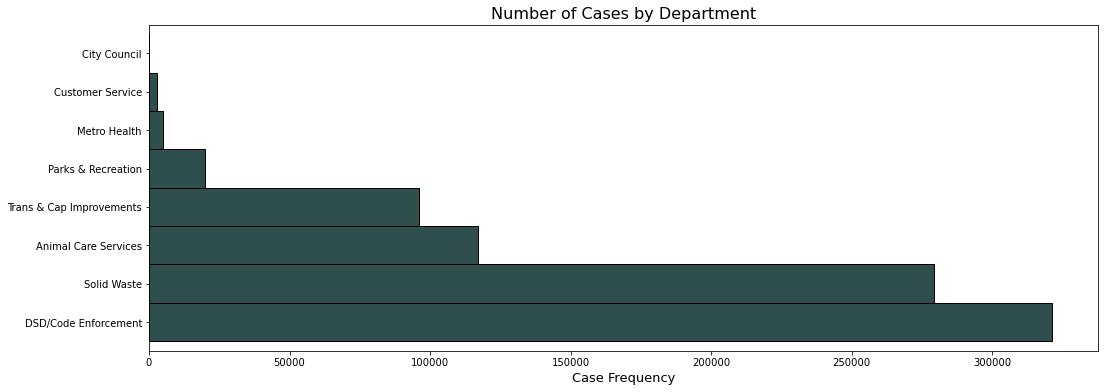

In [7]:
# plot cases per department
df.groupby('department').count()\
.toPandas()\
.set_index('department')['count']\
.sort_values(ascending = False)\
.plot.barh(color = 'darkslategrey', edgecolor = 'black', width = .999999, figsize = (17, 6))

plt.title('Number of Cases by Department', size = 16)
plt.ylabel('')
plt.xlabel('Case Frequency', size = 13);

Does the percentage of cases that are late vary by department?

In [8]:
# filter for cases that are late, group by department and aggregate counts on late cases
agg1 = df.filter(df.case_late == True)\
.groupby('department')\
.agg(count('case_late'))\
.withColumn('ratio_total', round(col('count(case_late)') / df.count(), 5))\
.withColumn('percent_out_of_all_cases', concat(round((col('count(case_late)') / df.count()) * 100, 2), lit('%')))\
.toPandas()\
.set_index('department')

agg1

,count(case_late),ratio_total,percent_out_of_all_cases
department,,,
Solid Waste,32945,0.03914,3.91%
Animal Care Services,23276,0.02765,2.77%
Trans & Cap Improvements,5411,0.00643,0.64%
Parks & Recreation,3797,0.00451,0.45%
Customer Service,2010,0.00239,0.24%
Metro Health,829,0.00098,0.1%
DSD/Code Enforcement,26235,0.03117,3.12%


Yes, it looks like there is some variance at a glance. Proportionally?

In [9]:
# assign variable to counts agg
cases = df.groupby('department').count()\
.withColumn('total_ratio', round(col('count') / df.count(), 5))\
.withColumn('total_percent', concat(round((col('count') / df.count()) * 100, 2), lit('%')))\
.toPandas()\
.set_index('department')

# assign variable to late case agg
lates = df.filter(df.case_late == True)\
.groupby('department')\
.agg(count('case_late'))\
.withColumn('percent_out_of_all_cases', concat(round((col('count(case_late)') / df.count()) * 100, 2), lit('%')))\
.toPandas()\
.set_index('department')

In [10]:
# use pandas to get bamboo sticks to go together on me n I get the banana
cases_and_lates = pd.concat([cases, lates], axis = 1)
cases_and_lates

,count,total_ratio,total_percent,count(case_late),percent_out_of_all_cases
department,,,,,
Solid Waste,279270,0.33179,33.18%,32945.0,3.91%
Animal Care Services,116915,0.13890,13.89%,23276.0,2.77%
Trans & Cap Improvements,96193,0.11428,11.43%,5411.0,0.64%
Parks & Recreation,19907,0.02365,2.37%,3797.0,0.45%
Customer Service,2849,0.00338,0.34%,2010.0,0.24%
Metro Health,5163,0.00613,0.61%,829.0,0.1%
City Council,33,0.00004,0.0%,NaN,NaN
DSD/Code Enforcement,321374,0.38181,38.18%,26235.0,3.12%


In [11]:
cal = cases_and_lates    # make this easier on myself
cal['ratio_late'] = cal['count(case_late)'] / cal['count']
cal['percent_late'] = cal['count(case_late)'] / cal['count'] * 100   # get proportion of late cases by department
# cal['percent_late'] = f"{round(cal['count(case_late)'] / cal['count'] * 100, 2)}%"
cal    # view results

,count,total_ratio,total_percent,count(case_late),percent_out_of_all_cases,ratio_late,percent_late
department,,,,,,,
Solid Waste,279270,0.33179,33.18%,32945.0,3.91%,0.117968,11.796827
Animal Care Services,116915,0.13890,13.89%,23276.0,2.77%,0.199085,19.908481
Trans & Cap Improvements,96193,0.11428,11.43%,5411.0,0.64%,0.056251,5.625149
Parks & Recreation,19907,0.02365,2.37%,3797.0,0.45%,0.190737,19.073693
Customer Service,2849,0.00338,0.34%,2010.0,0.24%,0.705511,70.551071
Metro Health,5163,0.00613,0.61%,829.0,0.1%,0.160566,16.056556
City Council,33,0.00004,0.0%,NaN,NaN,NaN,NaN
DSD/Code Enforcement,321374,0.38181,38.18%,26235.0,3.12%,0.081634,8.163386


In [12]:
cal.columns = ['cases', 'total_cases_ratio', 'percent_of_total_cases', 'late_cases', 'percent_late_of_all_cases', 'ratio_late', 'percent_late']
cal

,cases,total_cases_ratio,percent_of_total_cases,late_cases,percent_late_of_all_cases,ratio_late,percent_late
department,,,,,,,
Solid Waste,279270,0.33179,33.18%,32945.0,3.91%,0.117968,11.796827
Animal Care Services,116915,0.13890,13.89%,23276.0,2.77%,0.199085,19.908481
Trans & Cap Improvements,96193,0.11428,11.43%,5411.0,0.64%,0.056251,5.625149
Parks & Recreation,19907,0.02365,2.37%,3797.0,0.45%,0.190737,19.073693
Customer Service,2849,0.00338,0.34%,2010.0,0.24%,0.705511,70.551071
Metro Health,5163,0.00613,0.61%,829.0,0.1%,0.160566,16.056556
City Council,33,0.00004,0.0%,NaN,NaN,NaN,NaN
DSD/Code Enforcement,321374,0.38181,38.18%,26235.0,3.12%,0.081634,8.163386


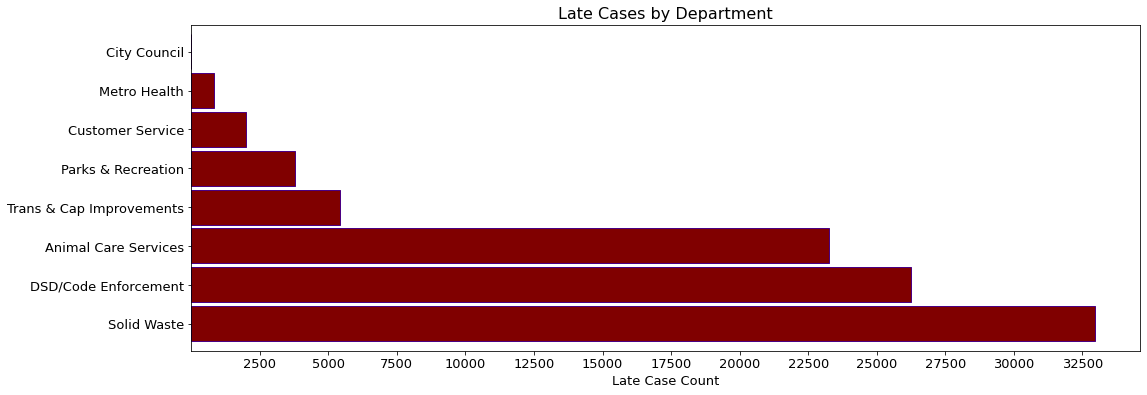

In [13]:
# visualize frequency of late cases by department
cal.late_cases.sort_values(ascending = False)\
.plot.barh(color = 'maroon', edgecolor = 'indigo', width = .9, figsize = (17, 6))

# clarity
plt.title('Late Cases by Department', size = 16)
plt.xlabel('Late Case Count', size = 13)
plt.ylabel('')
plt.xticks([2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500, 30000, 32500], size = 13)
plt.yticks(size = 13);

### Percent of Late Cases by Department
Out of the total number of cases in a department, these are the percentages of late cases.
* Solid Waste: 11.8%
* Animal Care Services: 19.9%
* Trans & Cap Improvements: 5.6%
* Parks & Recreation: 19.1%
* Customer Service: 70.6%
* Metro health: 16.1%
* City Council: ZERO PERCENT
* DSD/ Code Enforement: 8.2%

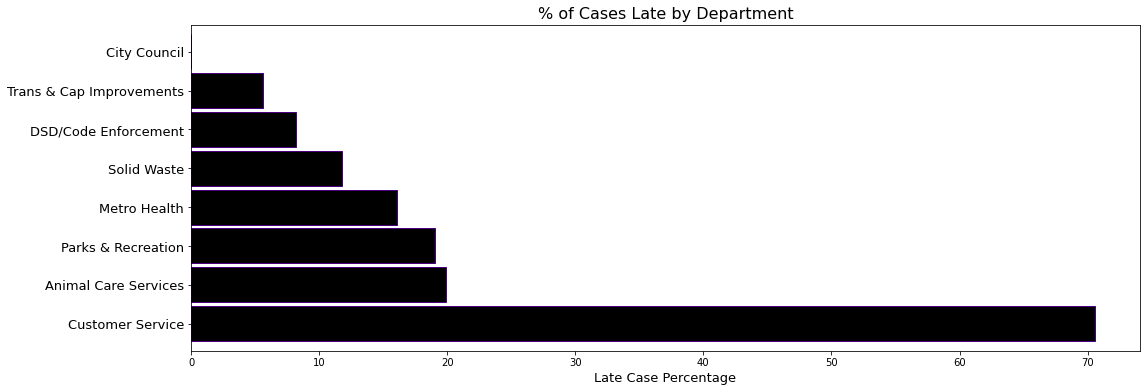

In [26]:
# visualize frequency of late cases by department
cal.percent_late.sort_values(ascending = False)\
.plot.barh(color = 'black', edgecolor = 'indigo', width = .9, figsize = (17, 6))

# clarity
plt.title('% of Cases Late by Department', size = 16)
plt.xlabel('Late Case Percentage', size = 13)
plt.ylabel('')
plt.yticks(size = 13);

On average, how late are the late cases by department?

In [14]:
# filter for late cases, then group by department and get average length of tardiness
df.filter(df.case_late == True)\
.groupby('department')\
.agg(round(mean('num_days_late'), 2).alias('avg_days_late'))\
.show(truncate = False)

+------------------------+-------------+
|department              |avg_days_late|
+------------------------+-------------+
|Solid Waste             |7.19         |
|Animal Care Services    |23.46        |
|Trans & Cap Improvements|10.6         |
|Parks & Recreation      |22.35        |
|Customer Service        |87.68        |
|Metro Health            |6.54         |
|DSD/Code Enforcement    |49.38        |
+------------------------+-------------+



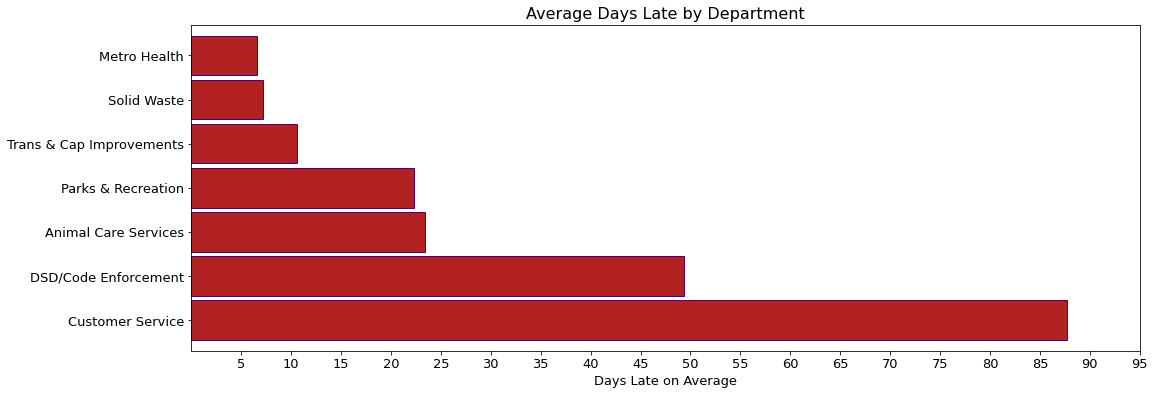

In [20]:
# convert spark frame to pandas frame for viz
avg_late = df.filter(df.case_late == True)\
.groupby('department')\
.agg(round(mean('num_days_late'), 2).alias('avg_days_late'))\
.toPandas()\
.set_index('department')['avg_days_late']\
.sort_values(ascending = False)

# visualize average days late by department
avg_late.plot.barh(color = 'firebrick', edgecolor = 'indigo', width = .9, figsize = (17, 6))
plt.title('Average Days Late by Department', size = 16)
plt.ylabel('')
plt.xlabel('Days Late on Average', size = 13)
plt.xticks([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95], size = 13)
plt.yticks(size = 13);

What is the service type that is the most late? Just for Parks & Rec?

For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

Does whether or not its a weekend matter for when a case is opened/closed?

On average, how many cases are opened a day for the Customer Service department?

Does the number of service requests for the solid waste department vary by day of the week?